In [1]:
import time
import numpy as np
from utils import *
from scipy.io import wavfile
from keras.models import load_model
import soundfile as sf
import sounddevice as sd
import cv2
import os
import imutils
import subprocess
from gtts import gTTS 
from pydub import AudioSegment
AudioSegment.converter = "C:/Users/ankit/Major Project/ffmpeg.exe"
from IPython.display import Audio

Using TensorFlow backend.


In [2]:
# load the COCO class labels our YOLO model was trained on
LABELS = open(r"C:\Users\ankit\Major Project\coco.names").read().strip().split("\n")
texts = []
hazard_obj = ["knife","fork","scissors"]
alert_obj = ["traffic light","stop sign","parking meter","fire hydrant"]

np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(r"C:\Users\ankit\Major Project\yolov4.cfg", r"C:\Users\ankit\Major Project\yolov4.weights")

# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

[INFO] loading YOLO from disk...


In [3]:
def obj_detect():
    fourcc= cv2.VideoWriter_fourcc(*'DIVX')
    out=cv2.VideoWriter('Object_detection.avi',fourcc,20.0, (640,480))
    cap = cv2.VideoCapture(0)
    time.sleep(5)
    frame_count = 0
    start = time.time()
    first = True
    frames = []
    flag = 0
    while True:
        frame_count += 1
        # Capture frame-by-frameq
        ret, frame = cap.read()
        frame = cv2.flip(frame,1)
        frames.append(frame)

        if frame_count == 300:
            break
        if ret:
            key = cv2.waitKey(1)
            if frame_count % 60 == 0:
                end = time.time()
                # grab the frame dimensions and convert it to a blob
                (H, W) = frame.shape[:2]
                # construct a blob from the input image and then perform a forward
                # pass of the YOLO object detector, giving us our bounding boxes and
                # associated probabilities
                blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
                net.setInput(blob)
                layerOutputs = net.forward(ln)

                # initialize our lists of detected bounding boxes, confidences, and
                # class IDs, respectively
                boxes = []
                confidences = []
                classIDs = []
                centers = []

                # loop over each of the layer outputs
                for output in layerOutputs:
                    # loop over each of the detections
                    for detection in output:
                        # extract the class ID and confidence (i.e., probability) of
                        # the current object detection
                        scores = detection[5:]
                        classID = np.argmax(scores)
                        confidence = scores[classID]

                        # filter out weak predictions by ensuring the detected
                        # probability is greater than the minimum probability
                        if confidence > 0.5:
                            # scale the bounding box coordinates back relative to the
                            # size of the image, keeping in mind that YOLO actually
                            # returns the center (x, y)-coordinates of the bounding
                            # box followed by the boxes' width and height
                            box = detection[0:4] * np.array([W, H, W, H])
                            (centerX, centerY, width, height) = box.astype("int")

                            # use the center (x, y)-coordinates to derive the top and
                            # and left corner of the bounding box
                            x = int(centerX - (width / 2))
                            y = int(centerY - (height / 2))
                            # update our list of bounding box coordinates, confidences,
                            # and class IDs
                            boxes.append([x, y, int(width), int(height)])
                            confidences.append(float(confidence))
                            classIDs.append(classID)
                            centers.append((centerX, centerY))
                            flag = 1

                # apply non-maxima suppression to suppress weak, overlapping bounding
                # boxes
                idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

                # ensure at least one detection exists
                if len(idxs) > 0:
                    # loop over the indexes we are keeping
                    for i in idxs.flatten():
                        # extract the bounding box coordinates
                        (x, y) = (boxes[i][0], boxes[i][1])
                        (w, h) = (boxes[i][2], boxes[i][3])
                        # draw a bounding box rectangle and label on the frame
                        color = [int(c) for c in COLORS[classIDs[i]]]
                        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                        text = "{}: {:.4f}".format(LABELS[classIDs[i]],confidences[i])
                        cv2.putText(frame, text, (x, y - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                        
                        # find positions
                        centerX, centerY = centers[i][0], centers[i][1]

                        if centerX <= W/3:
                            W_pos = "left "
                        elif centerX <= (W/3 * 2):
                            W_pos = "center "
                        else:
                            W_pos = "right "

                        if centerY <= H/3:
                            H_pos = "top "
                        elif centerY <= (H/3 * 2):
                            H_pos = "mid "
                        else:
                            H_pos = "bottom "
                            
                        print(text)

                        if LABELS[classIDs[i]] in hazard_obj:
                            obj_present = "Beware there's a " + LABELS[classIDs[i]] + " at " + H_pos + W_pos
                        elif LABELS[classIDs[i]] in alert_obj:
                            obj_present = "Alert! " + LABELS[classIDs[i]] + " at " + H_pos + W_pos
                        else:
                            obj_present = H_pos + W_pos + LABELS[classIDs[i]]
                        if obj_present not in texts:
                            texts.append(obj_present)

                final_texts = list(set(texts))
#                 print(final_texts)
                cv2.imwrite("Output.jpg", frame)

                if final_texts:
                    str1 = ', '
                    description = str1.join(final_texts)
                    tts = gTTS(description, lang='en')
    #                 tts.save('tts.wav')
    #                 tts = AudioSegment.from_mp3("tts.mp3")
    #                 subprocess.call(["ffplay", "-nodisp", "-autoexit", "tts.mp3"])
    #                 tts = gTTS(text=label) #Provide the string to convert to speech
                    tts.save("obj_detected.wav") #save the string converted to speech as a .wav file
                    sound_file = "obj_detected.wav"
        if flag:
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]],confidences[i])
            cv2.putText(frame, text, (x, y - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        cv2.imshow("Object_Detection",frame)
        out.write(frame)

    cap.release()
    cv2.destroyAllWindows()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




C:\Users\ankit\anaconda3\envs\tf\lib\site-packages\keras\models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '
C:\Users\ankit\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\ankit\Major Project\utils.py:124: RuntimeWarning: invalid value encountered in true_divide
  data = np.int16(data / np.max(np.abs(data)) * 32767)
C:\Users\ankit\anaconda3\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:7702: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


person: 0.8658
cell phone: 0.9925
person: 0.9886
cell phone: 0.9872
person: 0.9549
bottle: 0.5932
cell phone: 0.9936
bottle: 0.9158
person: 0.8982


C:\Users\ankit\anaconda3\envs\tf\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\ankit\anaconda3\envs\tf\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


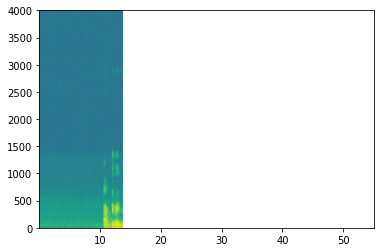

In [4]:
chime, fs = sf.read("audios/chime.wav", dtype='float32')
model = load_model("models/trigger word detection model.h5")
audio_arr = np.zeros((441000, ))
audio_arr = np.int16(audio_arr / np.max(np.abs(audio_arr)) * 32767)
spec_arr = rec_to_spec(audio_arr).swapaxes(0, 1)
model.predict(np.expand_dims(spec_arr, axis = 0))
while True:
    try:
        rate, new_aud_arr = wavfile.read("audios/current_recording.wav")
    except:
        time.sleep(0.05)
        continue
    new_spec_arr = rec_to_spec(new_aud_arr).swapaxes(0, 1)
    spec_arr = np.vstack([spec_arr, new_spec_arr])[-5511:, :]
    prediction = model.predict(np.expand_dims(spec_arr, axis = 0))
    if has_new_triggerword(np.squeeze(prediction, axis = 0), 2.5, 10, 0.5)==True:
        sd.play(chime, fs)
        obj_detect()
        break

In [5]:
sound_file = "obj_detected.wav"
Audio(sound_file, autoplay=True)

In [6]:
obj_detect()

person: 0.9684
person: 0.9908
cell phone: 0.8797
person: 0.8967
bottle: 0.8857
person: 0.9558
cell phone: 0.8786
bottle: 0.8485
